# NOTEBOOK LLAMA 3.2 - BINARY CLASSIFICATION (FINE-TUNING)

This notebook evaluates the LLama LLM using fine-tuning prompting for binary classification, distinguishing between normal and attack.

## 1. Objectives

The objective of this notebook is to evaluate the performance of the Llama LLM in a **fine-tuned binary classification** setting.

Specifically, this notebook aims to:
- Assess the model's ability to distinguish between **normal** and **attack** after being fine-tuned on labeled examples.
- Analyze its predictions and evaluate its suitability for binary threat detection tasks in IoT systems.

## 2. IMPORTS AND SETUP
Import the required python libraries, preprocessing, training (fine-tuning) and evaluation.

In [1]:
# pandas, json, re and os imports
import pandas as pd
import json
import os
import re
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# imports for LLM training
from datasets import Dataset, DatasetDict
from huggingface_hub import interpreter_login
from transformers import (
    TrainingArguments,
    EarlyStoppingCallback
)
from trl import SFTTrainer
from unsloth import FastLanguageModel, is_bfloat16_supported
# imports for evaluation (sklearn)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
# tqdm import
from tqdm import tqdm

# Login to Hugging Face Hub
interpreter_login()

/home/jorge/TFM/threatlogllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!

    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



## 3. PREPARE DATASET

The dataset is split into 70% for training, 15% for validation, and 15% for testing. The model is fine-tuned on the training set while using the validation set to monitor performance during training. After fine-tuning, the final evaluation is performed on the test set.

In [2]:
# Define file path
file_path = "../../../data/prompts/binary_instructions.jsonl"

# Check if file exists
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Read JSONL file line by line
samples = []
with open(file_path, "r", encoding="utf-8") as f:
    for line in f:
        sample = json.loads(line.strip())  # Load each line as a JSON object
        samples.append({"text": sample["Prompt"]})  # Extract the prompt field

# Convert into Hugging Face Dataset format
dataset_dict = {"full": Dataset.from_list(samples)}
dataset = DatasetDict(dataset_dict)

# Verify first example
print(dataset["full"][0])

{'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.\n### Instruction:\nYou are a cybersecurity expert specializing in IoT security. Your task is to analyze network logs and determine whether the given log data indicates a potential attack. Only provide a response if this log data indicates a potential attack or normal traffic.\n### Question:\n- The length of the DNS query is: 0\n- The MQTT protocol name used is: 0\n- The MQTT message type is: 0\n- The MQTT topic is: 0\n- The MQTT connection acknowledgment flags are: 0\n- TCP options set in the packet are: 0\n- TCP destination port is: 53316.0\n### Response:\n<think>\nThis log data is normal traffic.\n</think>'}


In [3]:
# Shuffle the dataset
dataset = dataset["full"].shuffle(seed=42)

# Split dataset into train (70%), validation (15%), test (15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))

# Ensure the split sizes are correct
train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# Print sizes
print(f"Train Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")
print(f"Test Samples: {len(test_dataset)}")

Train Samples: 8400
Validation Samples: 1800
Test Samples: 1800


## 4. PREPARE LLM

Load the Llama language model from Unsloth with specific configuration parameters for fine-tuning.

In [4]:
# Define model loading parameters
max_seq_length = 2048 
dtype = None 
load_in_4bit = True

# Load the Llama LLM with Unsloth's FastLanguageModel utility
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-3B-unsloth-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2025.2.15: Fast Llama patching. Transformers: 4.49.0.
   \\   /|    GPU: NVIDIA GeForce RTX 4060 Laptop GPU. Max memory: 7.996 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [5]:
# Get the model's config
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj", "gate_proj",
        "up_proj", "down_proj"
    ],
    lora_alpha=16,
    lora_dropout=0,  
    bias="none",
    use_gradient_checkpointing="unsloth",  
    random_state=3407,
    use_rslora=False,
    loftq_config=None,
)

# Reach the model for training
FastLanguageModel.for_training(model)

Unsloth 2025.2.15 patched 28 layers with 28 QKV layers, 28 O layers and 28 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=3072, out_features=3072, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=3072, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

## 5. PREPARE DATASET WITH EOS

In this section, each sample in the dataset is formatted to include an end-of-sentence (EOS) token.  
This ensures proper termination of sequences during training and improves model understanding of prompt boundaries.

In [6]:
EOS_TOKEN = tokenizer.eos_token  # Ensure each training sample has an EOS token

# Formatting function to structure data properly
def formatting_prompts_func(examples):
    texts = []
    for entry in examples["text"]:  # "text" is the key in our dataset
        text = entry + EOS_TOKEN  # Append EOS token
        texts.append(text)
    return {"text": texts}

# Apply formatting
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)
val_dataset = val_dataset.map(formatting_prompts_func, batched=True)
test_dataset = test_dataset.map(formatting_prompts_func, batched=True)

# Print an example formatted sample
print(train_dataset["text"][0])

Map: 100%|██████████| 1800/1800 [00:00<00:00, 99921.21 examples/s]

Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request. Before answering, think carefully about the question and create a step-by-step chain of thoughts to ensure a logical and accurate response.
### Instruction:
You are a cybersecurity expert specializing in IoT security. Your task is to analyze network logs and determine whether the given log data indicates a potential attack. Only provide a response if this log data indicates a potential attack or normal traffic.
### Question:
- The length of the DNS query is: 0.0
- The MQTT protocol name used is: 0.0
- The MQTT message type is: 0.0
- The MQTT topic is: 0.0
- The MQTT connection acknowledgment flags are: 0.0
- TCP options set in the packet are: 0
- TCP destination port is: 0.0
### Response:
<think>
This log data is an attack!!.
</think><|end_of_text|>


## 6. INITIALIZE THE SFTTrainer FOR FINE-TUNING

This section initializes the `SFTTrainer` with the model, tokenizer, and prepared datasets.  
It sets training arguments such as learning rate, batch size, evaluation strategy, and checkpointing.  
The model will be fine-tuned using supervised learning and validated on the evaluation set.

In [7]:
# Prepare the trainer, with SFTTrainer and TrainingArguments
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    max_seq_length=max_seq_length,
    dataset_num_proc=2,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=500,
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=10,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs_llama",
        eval_strategy="steps",  
        save_strategy="steps", 
        save_total_limit=2,  
        metric_for_best_model="eval_loss", 
        load_best_model_at_end=True,  
        greater_is_better=False,  
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop if loss doesn't improve in 3 evaluations
)

Map (num_proc=2):   0%|          | 0/8400 [00:00<?, ? examples/s]

Map (num_proc=2): 100%|██████████| 1800/1800 [00:03<00:00, 474.89 examples/s]


## 7. TRAINING MODEL

In this section, the model is fine-tuned for up to 500 steps.  
Evaluation is performed on the validation set every 10 steps, and early stopping is applied if no improvement is observed for 3 consecutive evaluations.

In [8]:
# Start fine-tuning
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 8,400 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 500
 "-____-"     Number of trainable parameters = 24,313,856


Step,Training Loss,Validation Loss
10,2.192700,0.941043
20,0.383900,0.178336
30,0.173000,0.140197
40,0.094500,0.100006
50,0.089100,0.095130
60,0.088700,0.089407
70,0.095900,0.084437
80,0.087500,0.086235
90,0.098600,0.082200
100,0.083800,0.080596


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [9]:
# Save fine-tuned model and tokenizer
trainer.save_model("fine-tuned-model/llama_binary_finetuned_model")  # Saves model weights
tokenizer.save_pretrained("fine-tuned-model/llama_binary_finetuned_model")  # Saves tokenizer config

('fine-tuned-model/llama_binary_finetuned_model/tokenizer_config.json',
 'fine-tuned-model/llama_binary_finetuned_model/special_tokens_map.json',
 'fine-tuned-model/llama_binary_finetuned_model/tokenizer.json')

## 8. COMPUTE PREDICTIONS

In this section, predictions are generated using the LLM (`predictions_binary`) and stored in a list. The corresponding true labels are also collected in a separate list (`actual_labels_binary`). 

Both lists will be used later to compute evaluation metrics.

In [10]:
# Ensure labels are properly converted to binary
def label_to_binary(response):
    response = response.lower()
    if "attack" in response:
        return 1  # Attack detected
    return 0  # Normal traffic

In [11]:
# Ensures optimized inference
FastLanguageModel.for_inference(model) 

# Initialize lists to store actual vs predicted labels
predictions_binary = []
actual_labels_binary = []

# Iterate over test dataset with tqdm for progress tracking
for sample in tqdm(test_dataset, desc="Processing Samples", unit="sample"):
    full_text = sample["text"]

    # Extract only the log entry (remove the response part)
    input_text = re.split(r"### Response:", full_text, maxsplit=1)[0].strip()

    # Extract actual label correctly (but don't pass it to the model)
    actual_label = label_to_binary(full_text.split("### Response:")[1].strip()) if "### Response:" in full_text else label_to_binary("Normal")

    # Tokenize input (ONLY the log entry)
    inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

    # Generate response
    outputs = model.generate(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=200,  # Keep short to avoid unnecessary text
        use_cache=True,
    )

    # Decode prediction and convert to binary
    predicted_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0].strip()
    predicted_label = label_to_binary(predicted_text.split("### Response:")[1].strip())

    # Store results
    predictions_binary.append(predicted_label)
    actual_labels_binary.append(actual_label)

Processing Samples:   0%|          | 0/1800 [00:00<?, ?sample/s]

Processing Samples: 100%|██████████| 1800/1800 [34:00<00:00,  1.13s/sample]


## 9. Compute Evaluation Metrics

In this section, standard evaluation metrics are computed to assess the model's performance. These include Accuracy, Precision, Recall, F1-Score, and the Confusion Matrix.

In [12]:
# Perform evaluation
accuracy = accuracy_score(actual_labels_binary, predictions_binary)
precision = precision_score(actual_labels_binary, predictions_binary, average="binary", pos_label=1)
recall = recall_score(actual_labels_binary, predictions_binary, average="binary", pos_label=1)
f1 = f1_score(actual_labels_binary, predictions_binary, average="binary", pos_label=1)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


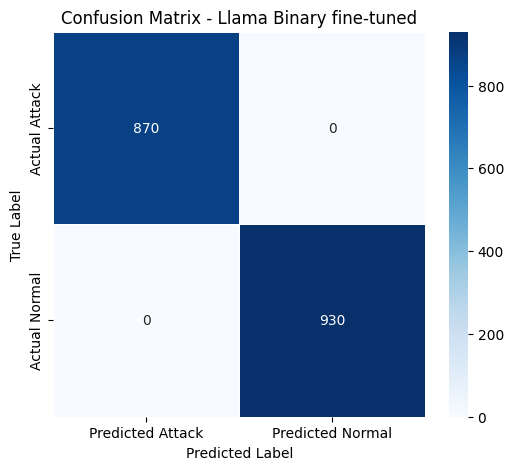

In [13]:
# Compute confusion matrix
cm = confusion_matrix(actual_labels_binary, predictions_binary)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual Attack", "Actual Normal"], columns=["Predicted Attack", "Predicted Normal"])

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Llama Binary fine-tuned")
plt.show()